
# Training 1D TFNO on Double-Well Potential

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from neuralop.models import TFNO, TFNO1d
from neuralop import Trainer
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
device = 'cpu'

In [2]:
# load data
dfinput = pd.read_csv("betasdoublewell.csv", header = None)
dfoutput = pd.read_csv("doublewellcommittors.csv", header = None)

In [3]:
dfinput = pd.DataFrame.astype(dfinput, 'float32')
dfoutput = pd.DataFrame.astype(dfoutput, 'float32')


In [4]:
ticklist = np.linspace(-1, 1, 4)
ticklist = np.round(ticklist, 2)

In [5]:
t = np.linspace(-1, 1, 200)
for i in range(len(t)):
    t[i] = (t[i]**2-1)**2

fig = plt.figure(figsize=(12, 12))
plt.plot(t)
plt.title('Sigmoid input', fontsize = 16)
plt.xticks(np.linspace(0, 200, 4),labels = ticklist)
plt.savefig("doublwell".pdf")



SyntaxError: EOL while scanning string literal (Temp/ipykernel_3708/2278047266.py, line 9)

In [6]:
datainput = pd.DataFrame.to_numpy(dfinput)

# datainput = np.transpose(datainput)

dataoutput = pd.DataFrame.to_numpy(dfoutput)

# dataoutput = np.transpose(dataoutput)



In [7]:
order = np.arange(len(datainput))
np.random.shuffle(order)

datainput = datainput[order]
dataoutput= dataoutput[order]
    




In [8]:
i = 300

In [9]:
# split into input/output, test + train

samples = len(datainput)

n_train = 800
n_test = samples - n_train

x_train = datainput[0:n_train,:]
x_test = datainput[n_train:samples,:]

y_train = dataoutput[0:n_train,:]
y_test = dataoutput[n_train:samples,:]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [10]:
x_train = x_train[::40]
y_train = y_train[::40]
len(x_train)

20

In [11]:
trainn = []
testt = []

# turn into dictionary

for i in range(len(x_train)):
    trainn.append({"x": x_train[i].unsqueeze(0), "y": y_train[i].unsqueeze(0)})
    

for i in range(len(x_test)):
    testt.append({"x": x_test[i].unsqueeze(0), "y": y_test[i].unsqueeze(0)})



In [12]:
# append grid?

s = x_train.size(-1)

grid = [-1,1]
grid1 = torch.linspace(grid[0], grid[1], s + 1)[0:-1].view(1,-1)
grid2 = torch.zeros(1, s)

samplegrid = torch.linspace(grid[0], grid[1], s)[0:-1].view(1,-1)

count = 0
subcount = 0
for i in range(s):
    if i % 2 == 0: 
        grid2[:,i] = samplegrid[:, subcount]
    else:
        grid2[:,i] = samplegrid[:, subcount ]
        subcount += 1
    


In [13]:


#use different resolution grid later?


for i in range(len(trainn)):
    trainn[i]["x"] = torch.stack([trainn[i]["x"], grid1, grid2])
#     trainn[i]["y"] = trainn[i]["y"].unsqueeze(1)


    trainn[i]["x"] = trainn[i]["x"].squeeze()
#     trainn[i]["y"] = trainn[i]["y"].squeeze()

    
for i in range(len(testt)):
    testt[i]["x"] = torch.Tensor(torch.stack([testt[i]["x"], grid1,grid2]))
#     testt[i]["x"] = torch.permute(testt[i]["x"],  (0,2,1))

    
#     testt[i]["y"] = testt[i]["y"].unsqueeze(1)
#     testt[i]["y"] = torch.permute(testt[i]["y"], (0,2,1))


    testt[i]["x"] = testt[i]["x"].squeeze()
#     testt[i]["y"] = testt[i]["y"].squeeze()
    



In [14]:
#1, 1 works here
    
batch_train = 1
batch_test = 1

# load data

    
train_loader = torch.utils.data.DataLoader(trainn, batch_size=batch_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testt, batch_size=batch_test, shuffle=False)

In [16]:
# for idx, sample in enumerate(train_loader):
#     print(idx)
# #     print("x")
#     print(sample["x"])
#     print(sample["x"].size())
#     print("y")
#     print(sample["y"])
#     print(sample["y"].size())

    
# # x is double tensor wrapped?    

We create a tensorized FNO model



In [15]:
model = TFNO1d(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', 
               rank=0.42, n_modes_height = 16)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 33089 parameters.


Create the optimizer



In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-5, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [17]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
l1loss = LpLoss(d=2, p=1)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss, "l1": l1loss}

In [18]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO1d(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(32, 32, 8), rank=(20, 20, 5))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
  )
  (projection): Projection(
    (fc1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (fc2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 8e-05
    lr: 8e-05
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x00000244927556A0>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at 0x0000024492755

Create the trainer



In [21]:
trainer = Trainer(model, n_epochs=1000,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


In [22]:
scheduler.load_state_dict(annealing)

NameError: name 'annealing' is not defined

In [48]:
trainer.train(train_loader, test_loader,
              None,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 20 samples
Testing on [200] samples         on resolutions ['test'].
Training on raw inputs of size x.shape=torch.Size([1, 3, 201]), y.shape=torch.Size([1, 1, 201])
.. patched inputs of size x.shape=torch.Size([1, 3, 201]), y.shape=torch.Size([1, 1, 201])
Raw outputs of size out.shape=torch.Size([1, 1, 201])
.. Processed (unpatched) outputs of size out.shape=torch.Size([1, 1, 201])
[0] time=0.46, avg_loss=0.0000, train_err=0.0014, test_h1=0.0018, test_l2=0.0018, test_l1=0.0019
[3] time=0.34, avg_loss=0.0000, train_err=0.0015, test_h1=0.0019, test_l2=0.0021, test_l1=0.0023
[6] time=0.36, avg_loss=0.0000, train_err=0.0019, test_h1=0.0020, test_l2=0.0024, test_l1=0.0026
[9] time=0.26, avg_loss=0.0001, train_err=0.0042, test_h1=0.0035, test_l2=0.0026, test_l1=0.0029
[12] time=0.21, avg_loss=0.0001, train_err=0.0064, test_h1=0.0059, test_l2=0.0056, test_l1=0.0061
[15] time=0.23, avg_loss=0.0001, train_err=0.0047, test_h1=0.0070, test_l2=0.0055, test_l1=0.0064
[18] time=0.21, avg

In [49]:
annealing = scheduler.state_dict()

In [29]:
# torch.save(model.state_dict(), '2000epochs.txt')
model.load_state_dict(torch.load('2000epochs.txt'))

<All keys matched successfully>

In [19]:
def MAE2(target,output):
    # for numpy simple calculations
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.abs(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

def l2(target, output): 
    x = torch.Tensor(output)
    y = torch.Tensor(target)
    error = torch.squeeze(torch.square(x - y))*(1/x.size(0))
    error = torch.sum(error)
                          
    return error

In [30]:
MAE2error = 0
l2error = 0
test_samples = test_loader.dataset
for data in test_samples: 
    x = data['x']
    y = data['y']

    out = model(x.unsqueeze(0))
    
    out = out.detach().numpy()[0][0]

    out = np.reshape(out, -1)

    y = y.detach().numpy()
    y = np.reshape(y, -1)

    MAE2error += MAE2(out, y)
    l2error = l2(out, y)


MAE2error = MAE2error / 200
l2error = l2error / 200

print(MAE2error)
print(np.sqrt(l2error))


tensor(0.0008)
tensor(2.7614e-05)


In [231]:
ticklist = np.linspace(-1, 1, 4)
ticklist = np.round(ticklist, 2)



Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



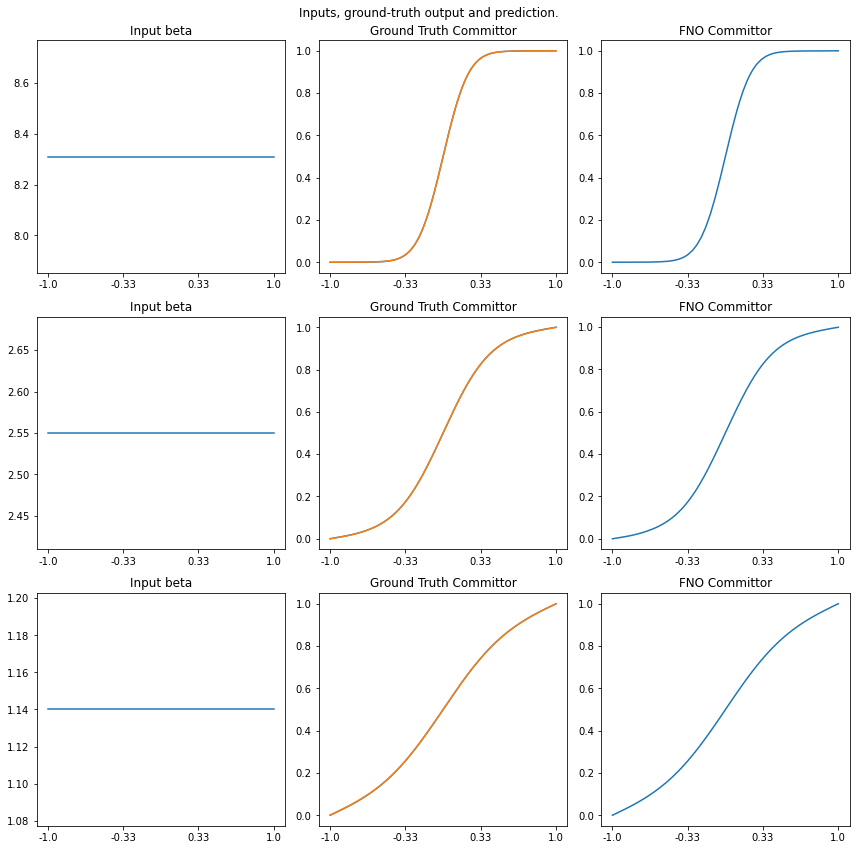

In [62]:
test_samples = test_loader.dataset

ticklist = np.linspace(-1, 1, 4)
ticklist = np.round(ticklist, 2)


fig = plt.figure(figsize=(12, 12))
for index in range(3):
    data = test_samples[index*60]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, 3*index+1)
    plt.plot(x[0])
    ax.set_title('Input beta')
    plt.xticks(np.linspace(0, 200, 4),labels = ticklist)
    
    ax = fig.add_subplot(3, 3, index*3+2)
    plt.plot(y.squeeze())
    plt.plot(out.squeeze().detach().numpy())
    ax.set_title('Ground Truth Committor')
    plt.xticks(np.linspace(0, 200, 4),labels = ticklist)

    ax = fig.add_subplot(3, 3, index*3 + 3)
    plt.plot(out.squeeze().detach().numpy())
    ax.set_title('FNO Committor')
    plt.xticks(np.linspace(0, 200, 4),labels = ticklist)


fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()

plt.savefig("1paramcommittor.pdf")



In [29]:
# train = train_loader.dataset

# fig = plt.figure(figsize=(7, 7))

# for index in range(3):

#     data = train[index]
#     # Input x
#     x = data['x']
#     # Ground-truth
#     y = data['y']
#     # Model prediction
#     out = model(x.unsqueeze(0))

#     ax = fig.add_subplot(3, 3, index*3 + 1)

#     plt.plot(x[0])
#     ax.set_title('Input x')
#     plt.xticks(np.linspace(0, 2048, 4),labels = ticklist)
    
    
#     ax = fig.add_subplot(3, 3, index*3 + 2)
#     plt.plot(y.squeeze())
#     ax.set_title('Ground Truth y')
#     plt.xticks(np.linspace(0, 2048, 4),labels = ticklist)


#     ax = fig.add_subplot(3, 3, index*3 + 3)
#     plt.plot(out.squeeze().detach().numpy())
#     ax.set_title('Predicted y')
#     plt.xticks(np.linspace(0, 2048, 4),labels = ticklist)



# fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
# plt.tight_layout()

In [30]:
# grid = np.linspace(-np.pi, np.pi, 1600)
# u0 = 1/(1+np.exp((10*grid)))
# plt.plot(u0)


In [362]:
dftestinput = pd.read_csv("backwardsvisinputstept1sigmoid.csv", header = None)
dftestoutput = pd.read_csv("backwardsvisoutputstept1sigmoid.csv", header = None)


dftestinput = pd.DataFrame.astype(dftestinput, 'float32')
dftestoutput = pd.DataFrame.astype(dftestoutput, 'float32')


In [364]:
#reversed sigmoid

testinput = pd.DataFrame.to_numpy(dftestinput)

testoutput = pd.DataFrame.to_numpy(dftestoutput)


# split into input/output, test + train

testinput = torch.from_numpy(testinput)
testoutput= torch.from_numpy(testoutput)

order = np.arange(len(testinput))
np.random.shuffle(order)

testinput = testinput[order]
testoutput = testoutput[order]

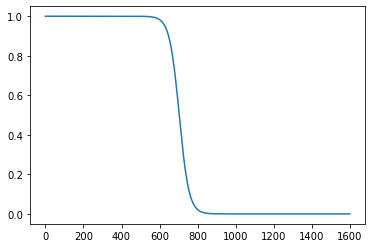

In [367]:
plt.plot(testinput[3])

In [368]:
test_values = []

# turn into dictionary

for i in range(len(testinput)):
    test_values.append({"x": testinput[i].unsqueeze(0), "y": testoutput[i].unsqueeze(0)})
    
# append grid?

s = testinput.size(-1)

grid = [0,1]
grid1 = torch.linspace(grid[0], grid[1], s + 1)[0:-1].view(1,-1)
grid2 = torch.zeros(1, s)

samplegrid = torch.linspace(grid[0], grid[1], s)[0:-1].view(1,-1)

count = 0
subcount = 0
for i in range(s):
    if i % 2 == 0: 
        grid2[:,i] = samplegrid[:, subcount]
    else:
        grid2[:,i] = samplegrid[:, subcount ]
        subcount += 1
    



    

In [369]:

#use different resolution grid later?


for i in range(len(test_values)):
    test_values[i]["x"] = torch.stack([test_values[i]["x"], grid1, grid2])
#     trainn[i]["y"] = trainn[i]["y"].unsqueeze(1)


    test_values[i]["x"] = test_values[i]["x"].squeeze()
#     trainn[i]["y"] = trainn[i]["y"].squeeze()


    
#1, 1 works here
    
batch_train = 16
batch_test = 16

# load data

    
test_values_loader = torch.utils.data.DataLoader(test_values, batch_size=batch_train, shuffle=False)

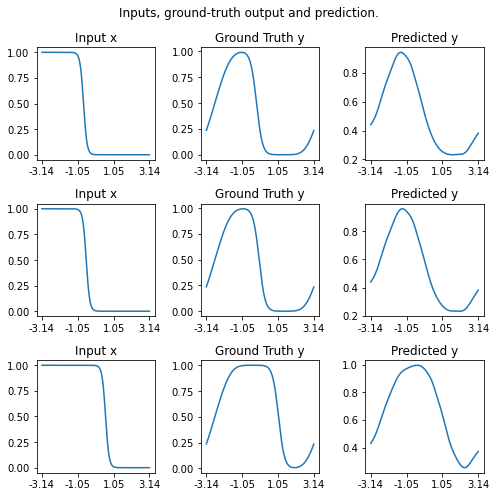

In [374]:
test_values_sample = test_values_loader.dataset

fig = plt.figure(figsize=(7, 7))

for index in range(3):
    data = test_values_sample[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)

    plt.plot(x[0])
    ax.set_title('Input x')
    plt.xticks(np.linspace(0, 1600, 4),labels = ticklist)
    
    
    ax = fig.add_subplot(3, 3, index*3 + 2)
    plt.plot(y.squeeze())
    ax.set_title('Ground Truth y')
    plt.xticks(np.linspace(0, 1600, 4),labels = ticklist)


    ax = fig.add_subplot(3, 3, index*3 + 3)
    plt.plot(out.squeeze().detach().numpy())
    ax.set_title('Predicted y')
    plt.xticks(np.linspace(0, 1600, 4),labels = ticklist)



fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()